In [5]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.table import Table
import corner

In [6]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/archived')
import statistics_ as sta
import mcmc as mcmc_

# Creating fake data assuming a model

We set the true parameters

In [7]:
free_p2 = False

In [8]:
p_1true, p_2true, p3_true = 1, 1, 1

We define the model

In [9]:
def model(x,p):
    
    p1, p2, p3 = p
    
    return p1*x*np.cos(p2*x) + p3

We create fake data described by the above model introducing fake noise

In [10]:
N = 20
noise = 0.01
x = np.linspace(0,1,N)
y_exp = model(x,[p_1true, p_2true, p3_true]) + np.random.randn(N)*noise

We store the `x` data and `y` measured data in an `astropy` table

# Covariance Matrix

We create arbitrary covariance matrix

In [11]:
Stat = sta.Statistics(N)

In [12]:
for i in range(100):
    
    y_real = model(x,[p_1true, p_2true, p3_true]) + np.random.randn(N)*noise
    
    Stat._add_realization(y_real)

In [13]:
Stat.estimate_covariance()
cov = Stat.covariance_matrix

<ErrorbarContainer object of 3 artists>

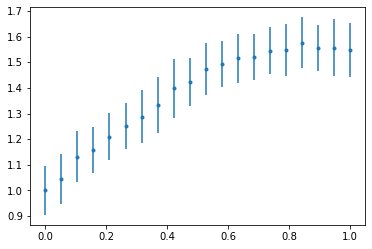

In [14]:
plt.errorbar(x,y_exp,np.sqrt(cov.diagonal()),fmt = '.')

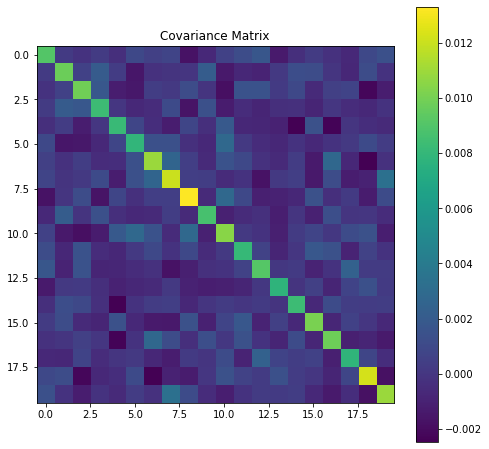

In [15]:
fig = plt.figure(figsize = (8,8))
plt.imshow(cov)
plt.title('Covariance Matrix')
plt.colorbar()
plt.show()

# Fit parameters using iMinuit

In [16]:
import iminuit
from iminuit import Minuit

In [17]:
def chi2(p):
    
    chi2=0
    
     # Calculated model at data x-values

    y_predict = np.array(model(x, p))

    delta = y_predict - y_exp

    inv_cov = np.linalg.inv(cov)

    chi2 =  np.sum(delta * inv_cov.dot(delta))
    
    return chi2

## Minimisation (we can fix some parameters, or define domains (see 

m = Minuit.from_array_func(chi2,
           (1,1, 1), limit_p1 = (-2,4), limit_p2 = (-2, 4), limit_p3 = (-2, 4),
           errordef = 1,
        name=("p1", "p2", "p3"))
## Find minimum with Migrad
m.migrad()
## Run Hessian for uncertainties
m.hesse()
## Run Minos for more robust and asymetric error bars
m.minos()
## Calculate chi2_min/dof (I have two free parameters here)
chi2min_dof =  m.fval/(len(x)-2)
# retrieve best-fit values
# Print all (values, parameters, errors Hess and Minos)
print(m.params)

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p1   │   0.99    │   0.16    │   -0.16    │    0.16    │   -2    │    4    │       │
│ 1 │ p2   │   0.99    │   0.11    │   -0.13    │    0.10    │   -2    │    4    │       │
│ 2 │ p3   │   1.00    │   0.05    │   -0.05    │    0.05    │   -2    │    4    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


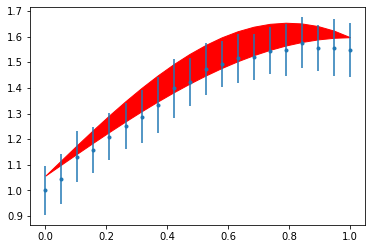

In [18]:
plt.errorbar(x,y_exp,np.sqrt(cov.diagonal()),fmt = '.')
y_up = model(x, [m.values['p1'] + m.merrors['p1'].upper, m.values['p2'] + m.merrors['p2'].upper, m.values['p3'] + m.merrors['p3'].upper])
y_down = model(x, [m.values['p1'] + m.merrors['p1'].lower, m.values['p2'] + m.merrors['p2'].lower, m.values['p3'] + m.merrors['p3'].upper])
plt.fill_between(x,y_up,y_down ,color = 'r', alpha = 1)
plt.show()

In [19]:
m.matrix()

,p1,p2,p3
p1,0.027,0.012,-0.007
p2,0.012,0.012,-0.002
p3,-0.007,-0.002,0.003


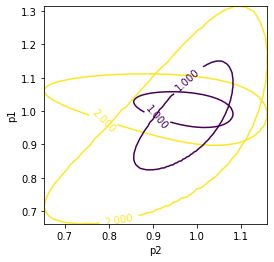

In [31]:
plt.figure(figsize = (4,4))
m.draw_mncontour('p2','p3')
m.draw_mncontour('p2','p1')

TypeError: cannot unpack non-iterable ContourSet object

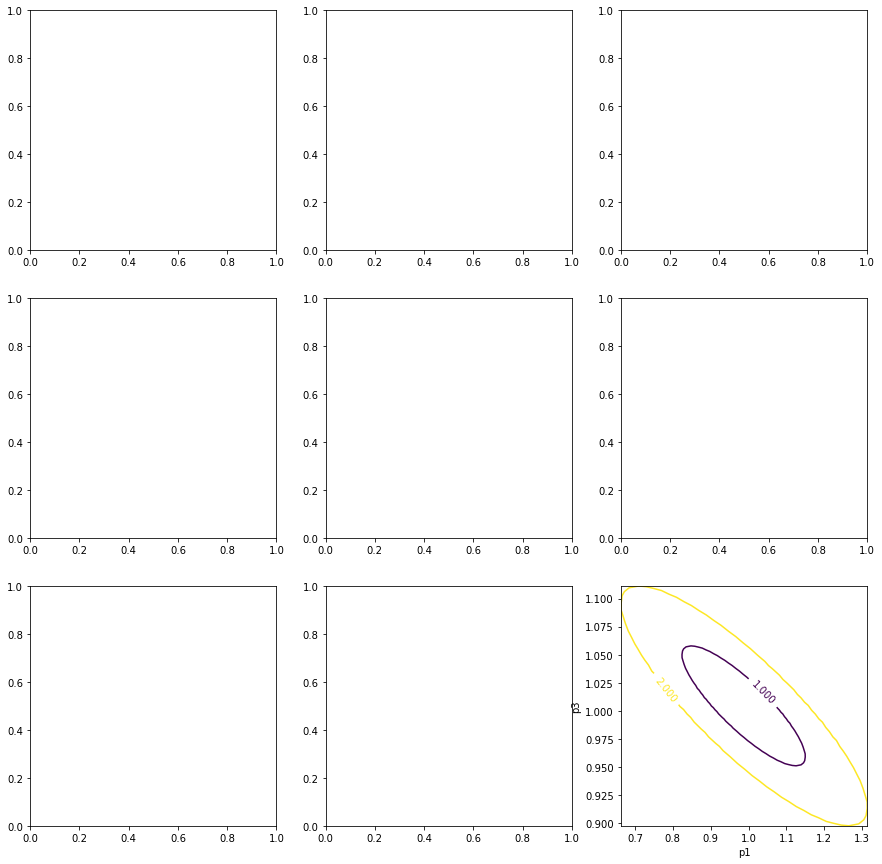

In [29]:
fig, axs = plt.subplots(3, 3, figsize = (15,15))
p = ['p1', 'p2', 'p3']
for i in range(3):
    px = p[i]
    for j in range(3):
        py = p[j]
        if i > j: continue
    axs[i,j].plot(x,y)
    m.draw_mncontour(px,py)
    axs[i,j].plot(x,y)
    

In [ ]:
m.draw_mncontour('p2','p1')